メモ：RMSDを比較することで、良い特徴量だけを選び出す。さらに、それらの良い特徴量だけで計算を行い、全部入りの計算結果と比較して性能差がどれくらいあるか調べる。性能差がそこまで変わらず、計算時間が減ったら嬉しい。KipfらによるSpatial GCNを用いる。

TODO:

RMSE, R2の計算方法を変える

記述子の標準化 or one-hot化

特徴量の重要性：逐次後退選択(SBS), ランダムフォレスト(scikitlearn), Permutation Feature Importance, PCAの負荷量

決定係数はMSEをノーマライズしたものなので、異なるモデルどうしの比較には使えない。

In [1]:
import pandas as pd
import pickle
import rdkit
from rdkit import Chem, RDLogger
from rdkit.Chem import PandasTools
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem.rdchem import HybridizationType
import rdkit.Chem.AllChem as AllChem
import torch
import torch_geometric as pyg
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch_geometric.utils import one_hot, scatter
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Dataset, InMemoryDataset, download_url, extract_zip
from torch_geometric.datasets import QM9
from torch_geometric.nn import global_add_pool
from torch_geometric.nn.conv import GCNConv
from torch_geometric.nn.models import MLP
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import one_hot, scatter
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import time
import pandas as pd
import os
import os.path as osp
import pickle
import sys
import shutil
from typing import Callable, List, Optional
import tqdm
from math import sqrt as sqrt
import backend
from backend import GCN, GCN3, MyQM9, RMSELoss, EarlyStopping, train
from sklearn.preprocessing import StandardScaler #標準化(P.116-)

In [12]:
backend.pre_reduce = None
dataset = MyQM9("./QM9/", pre_reduce=None)

In [3]:
dataset[0].x

tensor([[6., 0., 4., 4., 0., 0., 0., 1., 4.],
        [1., 0., 1., 1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0., 0., 0., 0.]])

In [ ]:
qm9csv = pd.read_csv("/home/higuchi/Pytorch/GCN/QM9/raw/gdb9.sdf.csv")
sdf = "/home/higuchi/Pytorch/GCN/QM9/raw/gdb9.sdf"
#mols = rdkit.Chem.SDMolSupplier(sdf, removeHs=False) #sdfからmolオブジェクトを生成
#mols = [m for m in mols if m is not None]
with open("mols_unprocessed", "rb") as f:
    mols = pickle.load(f)

# ETKDG Process (Mettya zikan kakaru...)
mols_ETKDG = []
mols_Hs = [rdkit.Chem.AddHs(mol) for mol in mols]
for mol in mols_Hs:
    ETKDG = AllChem.ETKDG()
    AllChem.EmbedMolecule(mol, ETKDG)
    mols_ETKDG.append(mol)

In [ ]:
# 3D structure generation with DeepChem (Hayai! approx. 2m)
import deepchem
featurizer = deepchem.feat.Mol2VecFingerprint()
mols_features = []
for mol in mols_Hs:
    features = featurizer.featurize(rdkit.Chem.MolToSmiles(mol))
    mols_features.append(features)

In [ ]:
with open("./results/honban/alpha/GCN_without_degree", "rb") as f:
    result_bak = pickle.load(f)
result_bak

Setting:
layer=3, hidden_layer=64
epoch_num=100

学習率を小さくするといいのかもしれない(valid lossがいいかんじ)

In [2]:
# Check convergence (calculate >200 epochs)
target_idx = 1 # 1:alpha
device = "cuda"
layer = 3
dim = 64
epoch_num = 100
batch_size = 32

pre_reduce = "degree"
backend.pre_reduce = pre_reduce
#dataset = MyQM9(root="./QM9", pre_reduce=pre_reduce)
print(dataset[0].x)
num_train = int(len(dataset)*0.9)
num_val = len(dataset) - num_train
train_set, valid_set = random_split(dataset, [num_train, num_val])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
model = GCN3(dataset=dataset).to(device)

# load model from alpha with all descs (honban)
# results in honban folder are used in poster. 
# starts from 201epoch 
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, weight_decay=5e-4)

start = time.time()
results = train(dataset=dataset, model=model, train_loader=train_loader, valid_loader=valid_loader, optimizer=optimizer, target_idx=target_idx, epoch_num=epoch_num)
end = time.time()
diff = end - start
        
results_dict = {"results":results, "time":diff}

filepath = "./results/alpha_all_lr0.001_stdscaled_90train"

with open(filepath, "wb") as f:
    pickle.dump(results_dict, f)
torch.save(model.state_dict(), filepath + "_model")

NameError: name 'dataset' is not defined

In [28]:
with open("./results/alpha_all_lr0.001_stdscaled", "rb") as f:
    result = pickle.load(f)
result["results"]

[{'Epoch': 1,
  'train_loss': 3.1631153020170695,
  'valid_loss': 1.6500057736935418},
 {'Epoch': 2,
  'train_loss': 1.7251805640695583,
  'valid_loss': 1.58287010835552},
 {'Epoch': 3,
  'train_loss': 1.5881939687083089,
  'valid_loss': 1.509835601217298},
 {'Epoch': 4,
  'train_loss': 1.4743951071624324,
  'valid_loss': 1.4374671539788142},
 {'Epoch': 5,
  'train_loss': 1.4079938618570467,
  'valid_loss': 1.3307390838934332},
 {'Epoch': 6,
  'train_loss': 1.3857695356453277,
  'valid_loss': 1.4627260925717342},
 {'Epoch': 7,
  'train_loss': 1.347306246715232,
  'valid_loss': 1.2858847993218812},
 {'Epoch': 8,
  'train_loss': 1.303766718081326,
  'valid_loss': 1.5286453666488815},
 {'Epoch': 9,
  'train_loss': 1.296722054317507,
  'valid_loss': 1.3009477311649649},
 {'Epoch': 10,
  'train_loss': 1.2518491029046939,
  'valid_loss': 1.1421458947775125},
 {'Epoch': 11,
  'train_loss': 1.2395060622739487,
  'valid_loss': 1.2204307574951854},
 {'Epoch': 12,
  'train_loss': 1.22758481933304

In [27]:
results

[{'Epoch': 1,
  'train_loss': 3.885541044937078,
  'valid_loss': 2.0035039936709227},
 {'Epoch': 2,
  'train_loss': 2.031336548013617,
  'valid_loss': 2.1204265352274794},
 {'Epoch': 3,
  'train_loss': 1.8571404521506107,
  'valid_loss': 1.8324694395356773},
 {'Epoch': 4,
  'train_loss': 1.7415190244653698,
  'valid_loss': 1.5343616900933692},
 {'Epoch': 5,
  'train_loss': 1.6073448831119863,
  'valid_loss': 1.4259921602340082},
 {'Epoch': 6,
  'train_loss': 1.5365970018440471,
  'valid_loss': 1.5056011122421413},
 {'Epoch': 7,
  'train_loss': 1.4772739002349033,
  'valid_loss': 1.3135644834024107},
 {'Epoch': 8,
  'train_loss': 1.4341551332135656,
  'valid_loss': 1.40861864122027},
 {'Epoch': 9,
  'train_loss': 1.4061411130690633,
  'valid_loss': 1.4046124430040858},
 {'Epoch': 10,
  'train_loss': 1.3972607090304126,
  'valid_loss': 1.7666995988206933},
 {'Epoch': 11,
  'train_loss': 1.3546137045822984,
  'valid_loss': 1.2637491372803313},
 {'Epoch': 12,
  'train_loss': 1.332944121541

In [26]:
std = StandardScaler()
for i in train_loader:
    i.x = std.fit_transform(i.x)
    print(i.x)
    print(type(i.x))
    break


[[ 0.87607894  0.          1.25426707 ... -0.3632233   1.4
   2.84046826]
 [ 1.24080379  0.          0.53615672 ...  2.75312734 -0.71428571
   0.55107791]
 [ 0.87607894  0.          1.25426707 ...  2.75312734 -0.71428571
  -0.59361726]
 ...
 [-0.9475453   0.         -0.90006399 ... -0.3632233  -0.71428571
  -0.59361726]
 [-0.9475453   0.         -0.90006399 ... -0.3632233  -0.71428571
  -0.59361726]
 [-0.9475453   0.         -0.90006399 ... -0.3632233  -0.71428571
  -0.59361726]]
<class 'numpy.ndarray'>


In [6]:
stdsc = StandardScaler()
train_loader = stdsc.fit_transform(train_loader)

TypeError: float() argument must be a string or a number, not 'DataLoader'

In [14]:
dataset.x

tensor([[ 1.7413, -0.9453,  0.8458,  ..., -0.9453, -0.4975,  0.8458],
        [ 1.4142, -0.7071,  1.4142,  ..., -0.7071, -0.7071, -0.7071],
        [ 1.4142, -0.7071,  1.4142,  ..., -0.7071, -0.7071, -0.7071],
        ...,
        [ 1.4142, -0.7071,  1.4142,  ..., -0.7071, -0.7071, -0.7071],
        [ 1.4142, -0.7071,  1.4142,  ..., -0.7071, -0.7071, -0.7071],
        [ 1.4142, -0.7071,  1.4142,  ..., -0.7071, -0.7071, -0.7071]])

In [13]:
sum([ 1.7413, -0.9453,  0.8458,  0.8458, -0.9453, -0.9453, -0.9453, -0.4975,
          0.8458])/9

-1.2335811384723961e-17

In [ ]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X = np.array([0,1,2,3,4])
X_std = stdsc.fit_transform(X)
X_std

honban_bakにあるalphaの計算結果のほうが、valid_loss>train_lossになっている。
何の設定を変えた？

lossをnum_graphsで割る場合、reduction=sumじゃないとだめ？(個数で二回割るな)

1エポック目でvalid_lossとtrain_lossの差が大きいのが気になる

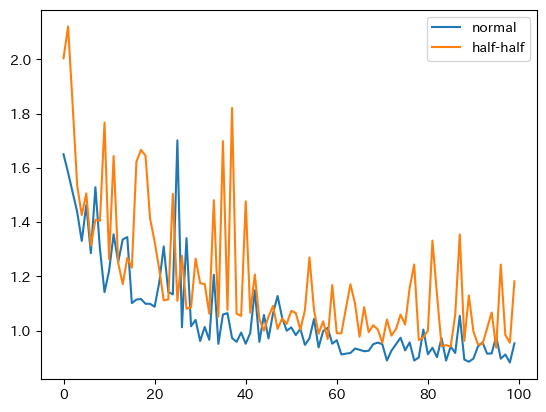

In [31]:
with open("./results/alpha_all_lr0.001_stdscaled", "rb") as f:
    result = pickle.load(f)
train_ = [i["train_loss"] for i in result["results"]]
valid_ = [i["valid_loss"] for i in result["results"]]
#plt.plot(train_)
plt.plot(valid_, label="normal")

with open("./results/alpha_all_lr0.001_stdscaled_halfvalid", "rb") as f:
    result = pickle.load(f)
train_ = [i["train_loss"] for i in result["results"]]
valid_ = [i["valid_loss"] for i in result["results"]]
#plt.plot(train_)
plt.plot(valid_, label="half-half")
# オレンジがvalid R2 
# honbanとhonban_bakでは、honban_bakのほうが、validR2が大きくなる現象の傾向が強い。(ように見えた)
plt.legend()

# half(valid:loss=50:50)の方がvalid lossが大きい。

In [2]:
# honban

descriptors = [None, "atomic_num", "formal_charge", "valence", "degree", "aromatic", "sp", "sp2", "sp3", "num_hs"]
#descriptors = [None, "degree", "aromatic", "sp", "sp2", "sp3", "num_hs"]

# DO NOT MODIFY THIS LIST!!!
target_list = ["mu", "alpha", "homo", "lumo", "gap", "r2", "zpve", "u0", "u298", "h298", "g298", "cv", "u0_atom", "u298_atom", "h298_atom", "g298_atom", "A", "B", "C"]
# Leave empty to predict all targets.
#targets_to_use = ["alpha", "u0", "r2"]
targets_to_use = ["alpha", "zpve", "u0", "cv", "mu", "u298", "h298", "g298", "homo", "lumo", "gap", "u298", "h298", "g298", "A", "B", "C"]
device = "cuda"
layer = 3
dim = 64
epoch_num = 2
batch_size = 32

# Check the following statement!!!
add_to_old_file = False
for pre_reduce in descriptors:
    backend.pre_reduce = pre_reduce
    """try:
        shutil.rmtree("./QM9")
    except FileNotFoundError:
        pass"""
    dataset = MyQM9(root="./QM9", pre_reduce=pre_reduce)
    print(dataset[0].x)
    num_train = int(len(dataset)*0.9)
    num_val = len(dataset) - num_train

    if targets_to_use:
        target_idx_list = [target_list.index(target) for target in targets_to_use]
    else:
        target_idx_list = [i for i in range(len(target_list))]
    
    for target_idx in target_idx_list:
        target_name = target_list[target_idx]
        print(target_idx)
        print(target_name)    
        # Change filepath when pre_reduce is set to None
        if pre_reduce:
            filepath = f"./results/train90RMSE//GCN_{target_name}_without_{pre_reduce}"
        else:
            filepath = f"./results/train90RMSE/GCN_{target_name}_all"
        if os.path.isfile(filepath):
            continue
        else:
            print(f"{target_name}_{pre_reduce}")

        train_set, valid_set = random_split(dataset, [num_train, num_val])
        #Dataloaderの生成
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

        if os.path.isfile(filepath):
            with open(filepath, "rb") as f:
                results_dict_old = pickle.load(f)
                results_old = results_dict_old["results"]
                initial_epoch_num = int(results_old[-1]["Epoch"])
                time_old = results_dict_old["time"]
        else:
            initial_epoch_num = 0
        
        model = GCN3(dataset=dataset).to(device)
        # Optimizerの初期化
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
        old_file_exists = False
        if os.path.isfile(filepath + "_model"):
            old_file_exists = True
            if add_to_old_file:
                model.load_state_dict(torch.load(filepath + "_model"))
                print("loaded old model")
        else:
            print("using brand new model")

        start = time.time()
        print(initial_epoch_num)
        results = train(dataset=dataset, model=model, train_loader=train_loader, valid_loader=valid_loader, optimizer=optimizer, target_idx=target_idx, epoch_num=epoch_num) #RMSE
        end = time.time()
        diff = end - start

        if old_file_exists:
            results = results_old + results
            diff += time_old
        
        results_dict = {"results":results, "time":diff}
        
        with open(filepath, "wb") as f:
            pickle.dump(results_dict, f)
        torch.save(model.state_dict(), filepath + "_model")

tensor([[6., 0., 4., 4., 0., 0., 0., 1., 4.],
        [1., 0., 1., 1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0., 0., 0., 0.]])
1
alpha
6
zpve
7
u0
11
cv
0
mu
mu_None
using brand new model
0
Epoch 1 | train_loss:1.14382670228572, valid_loss:1.2097525439227415, train_R2:0.32461855157237984, valid_R2:0.22956410582316242
Epoch 2 | train_loss:1.1045393442006215, valid_loss:1.1471096675087011, train_R2:0.37084780045501564, valid_R2:0.32584444832393766
8
u298
u298_None
using brand new model
0


KeyboardInterrupt: 

In [ ]:
os.mkdir("./results/honban")
for target  in target_list:
    os.mkdir(f"./results/honban/{target}")

sp3は全部悪くなるなぁ

In [ ]:
plt.figure(figsize=(15,10))
with open("./results/honban_bak/alpha/GCN_None", "rb") as f:
    result = pickle.load(f)
plt.plot([r["train_R2"] for r in result["results"]], label="訓練データセット")
plt.plot([r["valid_R2"] for r in result["results"]], label="検証データセット")
plt.xlabel("エポック数")
plt.ylabel("決定係数")
plt.xlim(0)
plt.legend(loc="upper right", borderaxespad=6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.rcParams["font.size"]=32

In [ ]:
with open("./results/honban/u0/GCN_without_sp3", "rb") as f:
    result = pickle.load(f)
    r2 = [i["valid_R2"] for i in result["results"]]
max(r2).item()

In [ ]:
import glob
def plot_train(filepath):
    filename = os.path.basename(filepath)
    with open(filepath, "rb") as f:
        result = pickle.load(f)
    plt.plot([i["train_loss"] for i in result["results"]], label=f"分極率(train)")

def plot_valid(filepath):
    filename = os.path.basename(filepath)
    with open(filepath, "rb") as f:
        result = pickle.load(f)
    plt.plot([i["valid_loss"] for i in result["results"]], label=f"分極率(validation)")

def plot_train_R2(filepath):
    filename = os.path.basename(filepath)
    with open(filepath, "rb") as f:
        result = pickle.load(f)
    plt.plot([i["train_R2"] for i in result["results"]], label=f"training_{filename}")

def plot_valid_R2(filepath):
    filename = os.path.basename(filepath)
    with open(filepath, "rb") as f:
        result = pickle.load(f)
    plt.plot([i["valid_R2"] for i in result["results"]], label=f"valid_{filename}")

def plot_train_errorbar(filepath, label=None):
    files = glob.glob(f"{filepath}_*")
    result_list = []
    for file in files:
        with open(file, "rb") as f:
            result = pickle.load(f)
            result = [i["train_loss"] for i in result["results"]]
        result_list.append(result)
    result_avg = np.mean(result_list, axis=0)
    result_error_upper = [max([result[i] for result in result_list]) - result_avg[i] for i in range(len(result_avg))]
    result_error_lower = [abs(min([result[i] for result in result_list]) - result_avg[i]) for i in range(len(result_avg))]
    plt.errorbar(x=[i for i in range(len(result_avg))] , y=result_avg, yerr=[result_error_upper, result_error_lower ])
    plt.plot(result_avg, label=label)

def plot_valid_errorbar(filepath):
    files = glob.glob(f"{filepath}_*")
    result_list = []
    for file in files:
        with open(file, "rb") as f:
            result = pickle.load(f)
            result = [i["valid_loss"] for i in result["results"]]
        result_list.append(result)
    result_avg = np.mean(result_list, axis=0)
    result_error_upper = [max([result[i] for result in result_list]) - result_avg[i] for i in range(len(result_avg))]
    result_error_lower = [abs(min([result[i] for result in result_list]) - result_avg[i]) for i in range(len(result_avg))]
    plt.errorbar(result_avg, yerr=[result_error_upper, result_error_lower])

In [ ]:
with open("./results/GCN_all", "rb") as f:
    result_all = pickle.load(f)

with open("./results/GCN_without_atomic_number", "rb") as f:
    result_atomic_number = pickle.load(f)

with open("./results/GCN_without_aromatic", "rb") as f:
    result_aromatic = pickle.load(f)

with open("./results/GCN_without_sp", "rb") as f:
    result_sp = pickle.load(f)

with open("./results/GCN_without_sp2", "rb") as f:
    result_sp2 = pickle.load(f)

with open("./results/GCN_without_sp3", "rb") as f:
    result_sp3 = pickle.load(f)

with open("./results/GCN_without_num_hs", "rb") as f:
    result_sp3 = pickle.load(f)

with open("./results/GCN_without_num_hs", "rb") as f:
    result_num_hs = pickle.load(f)



In [ ]:
results_all = glob.glob("./results/honban/*/GCN_without_atomic_number")
r2_dict = {}
for result in results_all:
    target = result.split("/")[-2]
    with open(result, "rb") as f:
        result_pickle = pickle.load(f)
        r2 = [result["valid_R2"] for result in result_pickle["results"]]
        r2_max = max(r2)
        r2_dict[target] = r2_max

xbar = [i for i in range(len(results_all))]
labels = r2_dict.keys()
plt.figure(figsize=[20,10])
plt.bar(xbar, r2_dict.values())
plt.xticks(xbar, labels=labels, fontsize=20)

results_all = glob.glob("./results/honban/*/GCN_all")
r2_dict = {}
for result in results_all:
    target = result.split("/")[-2]
    with open(result, "rb") as f:
        result_pickle = pickle.load(f)
        r2 = [result["valid_R2"] for result in result_pickle["results"]]
        r2_max = max(r2)
        r2_dict[target] = r2_max

xbar = [i for i in range(len(results_all))]
labels = r2_dict.keys()
plt.bar(xbar, r2_dict.values(), color="red")
plt.show()


In [ ]:
results_all = glob.glob("./results/honban/*/GCN_all")
r2_dict = {}
for result in results_all:
    target = result.split("/")[-2]
    with open(result, "rb") as f:
        result_pickle = pickle.load(f)
        r2 = [result["valid_R2"] for result in result_pickle["results"]]
        r2_max = max(r2)
        r2_dict[target] = r2_max

xbar = [i for i in range(len(results_all))]
labels = r2_dict.keys()
plt.figure(figsize=[20,10])
plt.bar(xbar, r2_dict.values())
plt.xticks(xbar, labels=labels, fontsize=20)
plt.show()
        

In [ ]:
files = glob.glob("./results/1031/GCN*")
files = [file for file in files if not file.endswith("model")]
result_list = []
labels = [file.split("_")[1] for file in files]
labels[0] = "all"

for file in files:
    with open(file, "rb") as f:
        result = pickle.load(f)
        result = [i["valid_loss"] for i in result["results"]]
        label = file.split("_")[1]
        result_best = max(result)
    result_list.append(result_best)
plt.bar([i for i in range(len(files))], result_list)


In [ ]:
files = [file for file in glob.glob("./results/1031/*") if not file.endswith("model")]
bestscore = []
for file in files:
    with open(file, "rb") as f:
        result = pickle.load(f)
    best = min([r["valid_loss"]for r in result["results"]])
    bestscore.append({"name":file.split("_")[-1], "best":best})
bestscore[0]["name"] = "全て"
xbar = [i for i in range(len(files))]
labels = ["全て","原子番号","芳香性", "sp混成", "sp2混成", "sp3混成", "水素原子数", "形式電荷", "原子価", "隣接原子数"]
plt.figure(figsize=[20,10])
plt.bar(xbar, [score["best"] for score in bestscore])
plt.xticks(xbar, labels=labels, fontsize=20)
plt.xlabel("記述子", fontsize=30)
plt.ylabel("RMSE", fontsize=30)
plt.show()

In [ ]:
files = [file for file in glob.glob("./results/1031/*") if not file.endswith("model")]
bestscore = []
for file in files:
    with open(file, "rb") as f:
        result = pickle.load(f)
    best = min([r["train_loss"]for r in result["results"]])
    bestscore.append({"name":file.split("_")[-1], "best":best})
bestscore[0]["name"] = "全て"
xbar = [i for i in range(len(files))]
labels = ["全て","原子番号","芳香性", "sp混成", "sp2混成", "sp3混成", "水素原子数", "形式電荷", "原子価", "隣接原子数"]
plt.figure(figsize=[20,10])
plt.bar(xbar, [score["best"] for score in bestscore])
plt.xticks(xbar, labels=[score["name"] for score in bestscore], fontsize=20)
plt.xlabel("記述子", fontsize=30)
plt.ylabel("RMSE", fontsize=30)
plt.show()

x: ノード特徴量

y: 正解ラベル

pos: 原子の座標

edge_index: エッジインデックス

edge_attr: エッジ特徴量(使えん)

ノード特徴量
type_idx: 原子の種類 
aromatic: 芳香性
sp: sp混成
sp2: sp2混成
sp3: sp3混成

In [ ]:
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
from torch_geometric.utils import to_networkx

data = dataset[7]
graph = to_networkx(data)
position = nx.spring_layout(graph)

#原子番号追加
elements = {
    1:"H",
    2:"He",
    3:"Li",
    4:"Be",
    5:"B",
    6:"C",
    7:"N",
    8:"O",
    9:"F"
}
atom_labels = {}
for i in range(data.num_nodes):
    atomic_num = int(data.x[i][0])
    atom_label = elements[atomic_num]
    atom_labels[i] = atom_label


pagerank = networkx.pagerank(graph) #pagerankはノードの中心性(重要性の指標)
pagerank_max = np.array(list(pagerank.values())).max()

#可視化する時のノード位置
draw_position = networkx.spring_layout(graph,seed=0)

plt.figure(figsize=(10,10))

networkx.draw_networkx_nodes(graph,
                            draw_position,
                            node_size=[v / pagerank_max * 1000 for v in pagerank.values()]
                            )

networkx.draw_networkx_edges(graph, draw_position, arrowstyle='-', alpha=0.2)
networkx.draw_networkx_labels(graph, draw_position, atom_labels, font_size=10)
plt.show()

In [ ]:
from rdkit import Chem
import networkx as nx
import matplotlib.pyplot as plt

# define the smiles string and covert it into a molecule sturcture ------------
smiles = 'CCO'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# define the function for coverting rdkit object to networkx object -----------     
def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())
        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
        
    return G

# conver rdkit object to networkx object --------------------------------------
graph = mol_to_nx(mol)

atoms = nx.get_node_attributes(graph, 'atom_symbol')

color_map = {'C': 'cyan',
             'O': 'red',
             'N': 'magenta',
             "H": "gray"}  

caffeine_colors = []
for idx in graph.nodes():
    if (graph.nodes[idx]['atom_symbol'] in color_map):
        caffeine_colors.append(color_map[graph.nodes[idx]['atom_symbol']])
    else:
        caffeine_colors.append('gray')
    
nx.draw(graph,
        labels=atoms,
        with_labels = True,
        node_color=caffeine_colors,
        node_size=800)

plt.show()

# print out the adjacency matrix ---------------------------------------------- 
matrix = nx.to_numpy_matrix(graph)
print(matrix)